### Set up

In [1]:
import os

import dotenv
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    HnswAlgorithmConfiguration,
    HnswParameters,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
)
from azure.search.documents.models import VectorizedQuery

dotenv.load_dotenv()

AZURE_SEARCH_SERVICE = os.getenv("AZURE_SEARCH_SERVICE")
AZURE_SEARCH_ENDPOINT = f"https://{AZURE_SEARCH_SERVICE}.search.windows.net"
AZURE_SEARCH_IMAGES_INDEX = "images-index4"
azure_credential = DefaultAzureCredential(exclude_shared_token_cache_credential=True)
search_client = SearchClient(AZURE_SEARCH_ENDPOINT, AZURE_SEARCH_IMAGES_INDEX, credential=azure_credential)

### Create search index for images

In [ ]:
index = SearchIndex(
    name=AZURE_SEARCH_IMAGES_INDEX, 
    fields=[
        SimpleField(name="id", type=SearchFieldDataType.String, key=True),
        SimpleField(name="filename", type=SearchFieldDataType.String),
        SearchField(name="embedding", 
                    type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
                    searchable=True, 
                    vector_search_dimensions=1024,
                    vector_search_profile_name="embedding_profile")
    ],
    vector_search=VectorSearch(
        algorithms=[HnswAlgorithmConfiguration(
                            name="hnsw_config",
                            kind=VectorSearchAlgorithmKind.HNSW,
                            parameters=HnswParameters(metric="cosine"),
                        )],
        profiles=[VectorSearchProfile(name="embedding_profile", algorithm_configuration_name="hnsw_config")]
    )
)

index_client = SearchIndexClient(endpoint=AZURE_SEARCH_ENDPOINT, credential=azure_credential)
index_client.create_index(index)

### Configure Azure Computer Vision multi-modal embeddings API 

In [2]:
import mimetypes
import os

import requests
from PIL import Image

token_provider = get_bearer_token_provider(azure_credential, "https://cognitiveservices.azure.com/.default")
AZURE_COMPUTERVISION_SERVICE = os.getenv("AZURE_COMPUTERVISION_SERVICE")
AZURE_COMPUTER_VISION_URL = f"https://{AZURE_COMPUTERVISION_SERVICE}.cognitiveservices.azure.com/computervision/retrieval"

def get_model_params():
    return {"api-version": "2023-02-01-preview", "modelVersion": "latest"}

def get_auth_headers():
    return {"Authorization": "Bearer " + token_provider()}

def get_image_embedding(image_file):
    mimetype = mimetypes.guess_type(image_file)[0]
    url = f"{AZURE_COMPUTER_VISION_URL}:vectorizeImage"
    headers = get_auth_headers()
    headers["Content-Type"] = mimetype
    # add error checking
    response = requests.post(url, headers=headers, params=get_model_params(), data=open(image_file, "rb"))
    if response.status_code != 200:
        print(image_file, response.status_code, response.json())
    return response.json()["vector"]

def get_text_embedding(text):
    url = f"{AZURE_COMPUTER_VISION_URL}:vectorizeText"
    return requests.post(url, headers=get_auth_headers(), params=get_model_params(),
                         json={"text": text}).json()["vector"]

### Add image vectors to search index

In [ ]:
for image_file in os.listdir("product_images"):
    image_embedding = get_image_embedding(f"product_images/{image_file}")
    search_client.upload_documents(documents=[{
        "id": image_file.split(".")[0],
        "filename": image_file,
        "embedding": image_embedding}])

### Query using an image

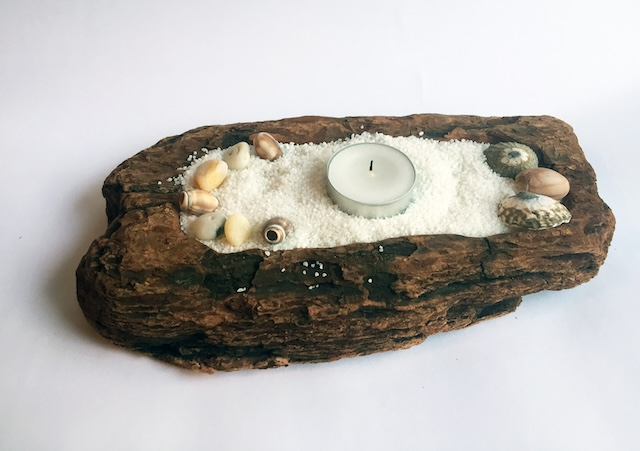

In [3]:
query_image = "query_images/tealightsand_side.jpg"
Image.open(query_image)

In [4]:
query_vector = get_image_embedding(query_image)
r = search_client.search(None, vector_queries=[
    VectorizedQuery(vector=query_vector, k_nearest_neighbors=3, fields="embedding")])
all = [doc["filename"] for doc in r]
for filename in all:
    print(filename)

tealightsand_night.jpg
singletealight1_side.jpg
doubletealight1_aboveside.jpg


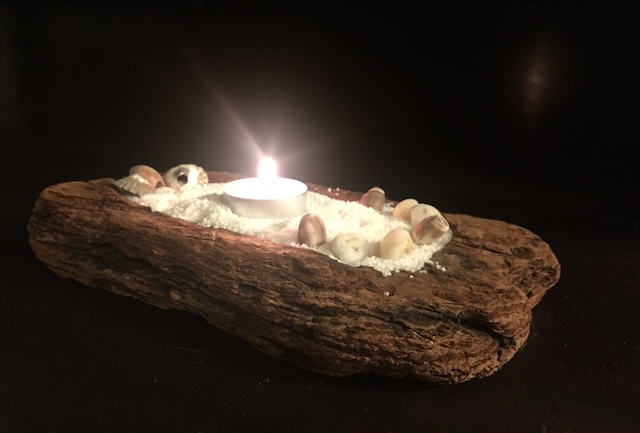

In [5]:
Image.open("product_images/" + all[0])

In [12]:
query_vector = get_text_embedding("lion king")
r = search_client.search(None, vector_queries=[
    VectorizedQuery(vector=query_vector, k_nearest_neighbors=3, fields="embedding")])
all = [doc["filename"] for doc in r]
for filename in all:
    print(filename)

hakunamatata_top.jpg
matatamagnet_fridge.jpg
amulet1_fullshot.jpg


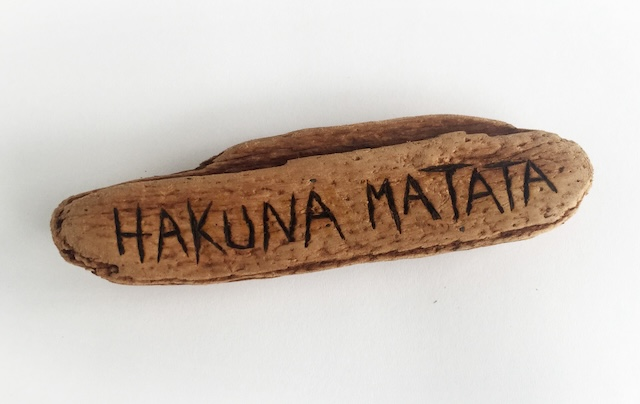

In [13]:
Image.open("product_images/" + all[0])